# showing the pipeline

In [1]:
from owkin_mm_dream import load_process_data, make_dataset, show_metrics

In [2]:
from sklearn import preprocessing
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
syn_login = "jkobject"
syn_password = "QXAxTW2s4AcRjaz"

In [5]:
rna_data, unc_clinical_data = load_process_data(syn_login, syn_password)

Welcome, jkobject!


here is our clinical data: 
               category  ... active
names                    ...       
D_OS_FLAG      response  ...    1.0
Study                id  ...    1.0
D_Age       demographic  ...    1.0
D_PFS_FLAG     response  ...    1.0
D_ISS          response  ...    1.0
D_OS           response  ...    1.0
D_Gender    demographic  ...    1.0
D_PFS          response  ...    1.0

[8 rows x 10 columns]
the rna data has 734 samples
downloading gene names from biomart


/home/jeremie/owkin_MM_DREAM/owkin_mm_dream/__init__.py:87: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  explanation_table.loc[set(clinical_data.columns) & set(explanation_table.index)]
/home/jeremie/owkin_MM_DREAM/owkin_mm_dream/__init__.py:108: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  rna_data = rna_data.loc[set(gene_names.index) & set(rna_data.index)]


In [18]:
X = make_dataset(rna_data, unc_clinical_data)


We are using these pathways & genesets: 
['BIOCARTA_DEATH_PATHWAY', 'BIOCARTA_CELLCYCLE_PATHWAY', 'BIOCARTA_ERK_PATHWAY', 'BIOCARTA_NFKB_PATHWAY', 'BIOCARTA_P53_PATHWAY', 'BIOCARTA_RAS_PATHWAY', 'BORTEZOMIB_ABNORMALITY_OF_CHROMOSOME_STABILITY', 'REACTOME_ANTIGEN_PROCESSING_UBIQUITINATION_PROTEASOME_DEGRADATION', 'REACTOME_DNA_REPAIR', 'UAMS17', 'THALIDOMIDE']


### generating the output data


In [19]:
Y = (
    unc_clinical_data.replace({"FALSE": 0, "TRUE": 1})["to_pred"]
    .loc[X.index]
    .values
)

### scaling the data


In [21]:
predict_on = [
    "age",
    "stage",
    "PHF19",
    "BCL2A1",
    "BIOCARTA_DEATH_PATHWAY",
    "BIOCARTA_CELLCYCLE_PATHWAY",
    "BIOCARTA_ERK_PATHWAY",
    "BIOCARTA_NFKB_PATHWAY",
    "BIOCARTA_P53_PATHWAY",
    "BIOCARTA_RAS_PATHWAY",
    "BORTEZOMIB_ABNORMALITY_OF_CHROMOSOME_STABILITY",
    "REACTOME_ANTIGEN_PROCESSING_UBIQUITINATION_PROTEASOME_DEGRADATION",
    "REACTOME_DNA_REPAIR",
    "UAMS17",
    "THALIDOMIDE",
]

In [22]:
scaler = preprocessing.StandardScaler().fit(X[predict_on].values)
X_scaled = scaler.transform(X[predict_on].values)

### finding the best predictors

In [25]:
clf = LogisticRegression()
clf = clf.fit(X_scaled, Y)

best_pred = np.array(predict_on)[abs(clf.coef_[0]) > 0.2]
print("\nThe best predictors according to logistic regression are: \n")
print(best_pred)


The best predictors according to logistic regression are: 

['age' 'stage' 'PHF19' 'BIOCARTA_P53_PATHWAY' 'BIOCARTA_RAS_PATHWAY'
 'REACTOME_ANTIGEN_PROCESSING_UBIQUITINATION_PROTEASOME_DEGRADATION'
 'REACTOME_DNA_REPAIR' 'UAMS17']


### showing a few models' predictions



KNeighborsClassifier:



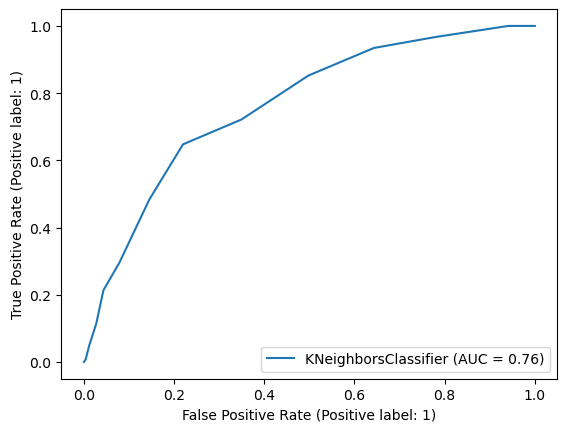

precision, recall, f1_score:
0.7032117093348159 0.7188328912466844 0.6828149370647434
k-fold CV score:
0.6916666666666669
a KNN with 15 neigbhors shows a lower f1 score overall (CV=100) but a really good AUC. However, this is likely due to overfitting.
_______________________________________


svm:



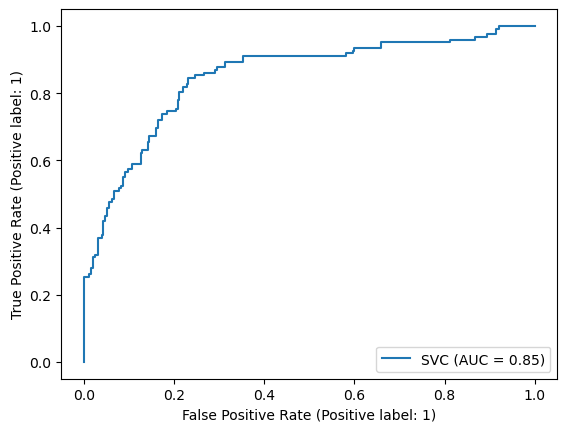

precision, recall, f1_score:
0.7820701695983681 0.7718832891246684 0.7426611753544143
k-fold CV score:
0.7050000000000002

SVM is able to get a very good precision and in medical applications, this is often what we are looking for: FPs need to be as low as possible. However, the kaplan-meyer curve is worrying. But it might be due to it being based on survival data whereas we are looking at risk / fast progression?
_______________________________________


LogisticRegression:



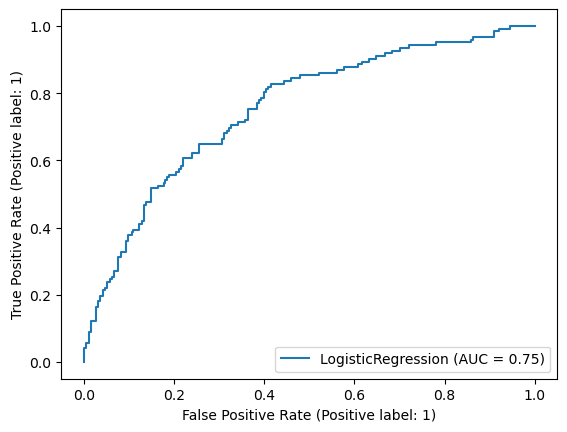

precision, recall, f1_score:
0.7011262919188603 0.7161803713527851 0.6752817462861146
k-fold CV score:
0.7108333333333335

logistic regression with elasticnet and a high l1_ratio shows a good f1 score. Lower precision, But by far the best K-M curve of all.


In [27]:
print("\n\nKNeighborsClassifier:\n")
clf = KNeighborsClassifier(n_neighbors=15)
clf = clf.fit(X_scaled, Y)
show_metrics(clf, X_scaled, Y)
print(
    "a KNN with 15 neigbhors shows a lower f1 score overall (CV=100) but a really good AUC. However, this is likely due to overfitting."
)

print("_______________________________________\n\n")
print("svm:\n")
clf = svm.SVC(C=0.9)
clf = clf.fit(X_scaled, Y)
show_metrics(clf, X_scaled, Y)
print(
    "\nSVM is able to get a very good precision and in medical applications, this is often what we are looking for: FPs need to be as low as possible. However, the kaplan-meyer curve is worrying. But it might be due to it being based on survival data whereas we are looking at risk / fast progression?"
)

print("_______________________________________\n\n")
print("LogisticRegression:\n")
clf = LogisticRegression(
    penalty="elasticnet", solver="saga", l1_ratio=1, max_iter=800, C=0.2
)
clf = clf.fit(X_scaled, Y)
show_metrics(clf, X_scaled, Y)
print(
    "\nlogistic regression with elasticnet and a high l1_ratio shows a good f1 score. Lower precision, But by far the best K-M curve of all."
)